In [ ]:
# init repo notebook
!git clone https://github.com/rramosp/ppdl.git > /dev/null 2> /dev/null
!mv -n ppdl/content/init.py ppdl/content/local . 2> /dev/null
!pip install -r ppdl/content/requirements.txt > /dev/null

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.optimizers import Adam
from IPython.display import display, Math
plt.style.use("ggplot")

2023-01-31 09:59:55.447534: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-31 09:59:55.851776: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-01-31 09:59:55.851803: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-01-31 09:59:55.921473: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-01-31 09:59:57.163539: W tensorflow/stream_executor/platform/de

In [2]:
tfd = tfp.distributions

## Approximating the Posterior
---

Another approach is to approximate the posterior distribution through variational inference.

We will use the same data samples as in previous notebooks.

/tmp/ipykernel_18354/967135023.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


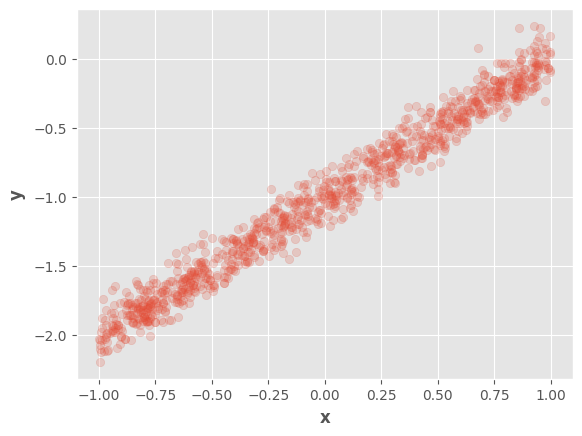

In [11]:
x = tf.random.uniform(
        shape = (1000, 1),
        minval = -1,
        maxval = 1
        )
X = tf.concat([x, tf.ones_like(x)], axis=1)

w_real = tf.constant([[1.0], [-1.0]])
e_real = tf.constant(0.1)

y = X @ w_real + tf.random.normal(shape=(1000, 1), mean=0, stddev=e_real)

fig, ax = plt.subplots()
ax.scatter(tf.squeeze(x), tf.squeeze(y), alpha=0.2)
ax.set_xlabel(r"$\mathbf{x}$")
ax.set_ylabel(r"$\mathbf{y}$")
fig.show()


In this case, we can use a surrogate posterior distribution $Q(\mathbf{w})$ to approximate $P(\mathbf{w} | \mathbf{y}, \mathbf{X}, E)$ through the minimization of the kullback-leibler divergence:

$$
KL(Q || P) = \int_{\mathbf{w}} Q(\mathbf{w}) \log \frac{Q(\mathbf{w})}{P(\mathbf{w} | \mathbf{y}, \mathbf{X}, E)} d\mathbf{w}
$$

From the Bayes rule, we obtain:

$$
KL(Q || P) = \int_{\mathbf{w}} Q(\mathbf{w}) \log{Q(\mathbf{w})} - \log{P(\mathbf{y}| \mathbf{w}, \mathbf{X}, E) P(\mathbf{w})} + \log(P(\mathbf{y}, \mathbf{X}, E)) d\mathbf{w}
$$

The term $P(\mathbf{y}, \mathbf{X}, E)$ does not depend on $\mathbf{w}$, therefore, the problem would be equivalent to minimizing the evidence lower bound function:

$$
ELBO(Q || P) = \underset{Q(\mathbf{w})}{\mathbb{E}}[\log Q(\mathbf{w}) - \log P(\mathbf{y}, \mathbf{w} | \mathbf{X}, E)]
$$

We can train a Bayesian linear regression with this approach, for instance, we can use the following surrogate posterior distribution:

$$
Q(\mathbf{w}) = N(\mathbf{w_{vi}}, \sigma_{vi})
$$

Therefore, we must learn its parameters:

In [12]:
w_vi = tf.Variable([0., 0.])
sigma_vi = tf.Variable(1.0)

Let's define a the surrogate posterior distribution $Q(\mathbf{w})$ that we'll fit:

In [13]:
surrogate_posterior = tfd.JointDistributionNamedAutoBatched({
    "w": tfd.Independent(tfd.Normal(loc=w_vi, scale=sigma_vi), reinterpreted_batch_ndims=1)
    })

Likewise, we can define the joint distribution $P(\mathbf{y}, \mathbf{w} | \mathbf{X}, E)$ according to the linear model that we want to learn:

In [14]:
model = tfd.JointDistributionNamedAutoBatched({
    "w": tfd.Normal(loc=tf.zeros(shape=(2, )), scale=2.0),
    "y": lambda w: tfd.Normal(loc=X @ tf.reshape(w, (-1, 1)), scale=e_real)
    })

From this model, we can obtain the distribution for different $\mathbf{w}$ values, since $\mathbf{y}$ is constant:

In [15]:
def log_prob(w):
    return model.log_prob(w=w, y=y)

Using these distributions, we can optimize the surrogate parameters using variational inference and gradient-based optimization:

In [16]:
optimizer = Adam(learning_rate=1e-3)
loss = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=log_prob,
        surrogate_posterior=surrogate_posterior,
        optimizer=optimizer,
        num_steps=5000,
        )

Let's see the learned parameters:

In [17]:
display(Math(r"\mathbf{w}"))
display(w_real)
display(Math(r"\mathbf{w_{vi}}"))
display(w_vi)

<IPython.core.display.Math object>

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[ 1.],
       [-1.]], dtype=float32)>

<IPython.core.display.Math object>

<tf.Variable 'Variable:0' shape=(2,) dtype=float32, numpy=array([ 1.0062337, -1.0054008], dtype=float32)>

Finally, we can visualize the surrogate posterior distribution:

In [18]:
w1_range = np.linspace(0.9, 1.1, 100)
w2_range = np.linspace(-1.1, -0.9, 100)
W1, W2 = np.meshgrid(w1_range, w2_range)
W_grid = np.concatenate([W1.reshape(-1, 1), W2.reshape(-1, 1)], axis=1)
probs = surrogate_posterior.prob(w=W_grid).numpy().reshape(W1.shape)

/tmp/ipykernel_18354/1450128339.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


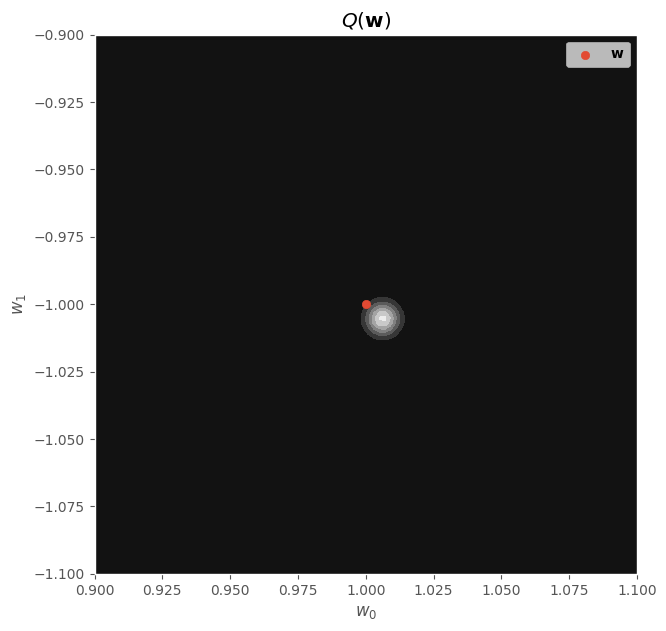

In [19]:
fig, ax = plt.subplots(figsize=(7, 7))
ax.contourf(W1, W2, probs, cmap="gray")
ax.scatter([w_real[0]], [w_real[1]], label=r"$\mathbf{w}$")
ax.set_xlabel(r"$w_0$")
ax.set_ylabel(r"$w_1$")
ax.set_title(r"$Q(\mathbf{w})$")
ax.legend()
fig.show()